In [1]:
!git clone https://github.com/Concyclics/ViT-Training-Benchmark-with-ColossalAI.git

Cloning into 'ViT-Training-Benchmark-with-ColossalAI'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 47 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), 121.59 KiB | 1.87 MiB/s, done.


In [2]:
cd ViT-Training-Benchmark-with-ColossalAI

/kaggle/working/ViT-Training-Benchmark-with-ColossalAI


In [3]:
!cat my_benchmark.sh

set -xe
pip install -r requirements.txt

export BS=8
export MEMCAP=0
export GPUNUM=2

for BS in 8 16 32 64 128 256
do
for PLUGIN in "torch_ddp" "torch_ddp_fp16" "low_level_zero" "gemini"
do
for iter in {1..3} 
do

MODEL_PATH="google/vit-base-patch16-224"
colossalai run \
  --nproc_per_node ${GPUNUM} \
  --master_port 29505 \
  vit_benchmark.py \
  --model_name_or_path ${MODEL_PATH} \
  --mem_cap ${MEMCAP} \
  --plugin ${PLUGIN} \
  --batch_size ${BS}

done
done
done


In [4]:
!bash my_benchmark.sh > log.txt 2> errors.txt

In [5]:
import pandas as pd

batchs = []
plugins = []
throughputs = []
memory_usages = []

with open('log.txt', 'r') as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if 'batch size per gpu' in lines[i]:
            line = lines[i].strip() + lines[i+1].strip() + lines[i+2].strip()
            batch, plugin, throughput, memory = line.split(',')
            batch = int(batch.split()[-1][7:][:-4])
            plugin = plugin.split()[-1]
            throughput = float(throughput.split()[-1][7:][:-4])
            memory_unit = memory.split()[-1][:-1]
            memory_usage = float(memory.split()[-2][7:][:-4])
            if memory_unit == 'MB':
                memory_usage /= 1024
            batchs.append(batch)
            plugins.append(plugin)
            throughputs.append(throughput)
            memory_usages.append(memory_usage)

test_log = pd.DataFrame({'batch': batchs, 'plugin': plugins, 'throughput':throughputs, 'memory_usage_per_gpu(GB)':memory_usages})
test_log.to_csv('benchmark.csv')
test_log

,batch,plugin,throughput,memory_usage_per_gpu(GB)
0,8,torch_ddp,41.7742,1.74
1,8,torch_ddp,45.3673,1.74
2,8,torch_ddp,44.8215,1.74
3,8,torch_ddp_fp16,96.4711,1.73
4,8,torch_ddp_fp16,99.3081,1.73
...,...,...,...,...
67,256,low_level_zero,169.3250,3.53
68,256,low_level_zero,169.9275,3.53
69,256,gemini,172.7707,2.98
70,256,gemini,172.5867,2.98


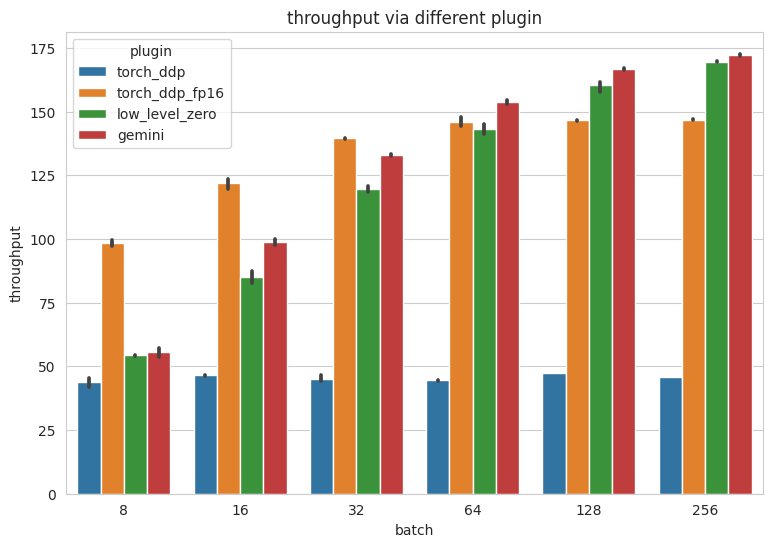

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(9, 6))
sns.barplot(x='batch', y='throughput', hue='plugin', data=test_log)
plt.title('throughput via different plugin')
plt.savefig('throughput.png')

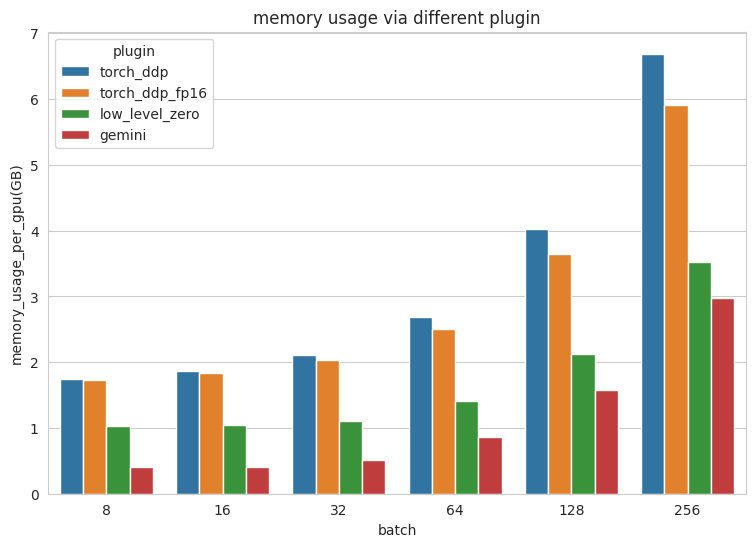

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(9, 6))
sns.barplot(x='batch', y='memory_usage_per_gpu(GB)', hue='plugin', data=test_log)
plt.title('memory usage via different plugin')
plt.savefig('memory.png')